# Image segmentation with CamVid

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [ ]:
!pip list

In [ ]:
gpu_mem_get()

GPUMemory(total=11441, free=11438, used=3)

In [ ]:
!pip install fastai==1.0.61

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path = untar_data(URLs.CAMVID)
path_ = '/content/drive/MyDrive/images/'
path = Path(path_)
path.ls()

[PosixPath('/content/drive/MyDrive/images/codes.txt'),
 PosixPath('/content/drive/MyDrive/images/images'),
 PosixPath('/content/drive/MyDrive/images/labels'),
 PosixPath('/content/drive/MyDrive/images/valid.txt'),
 PosixPath('/content/drive/MyDrive/images/pred'),
 PosixPath('/content/drive/MyDrive/images/temp')]

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

NameError: ignored

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

NameError: ignored

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [ ]:
get_y_fn(img_f)

In [ ]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

## Datasets

In [ ]:
#size = src_size//2

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=4
else:
  bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 11438MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=1)
        .normalize(imagenet_stats))

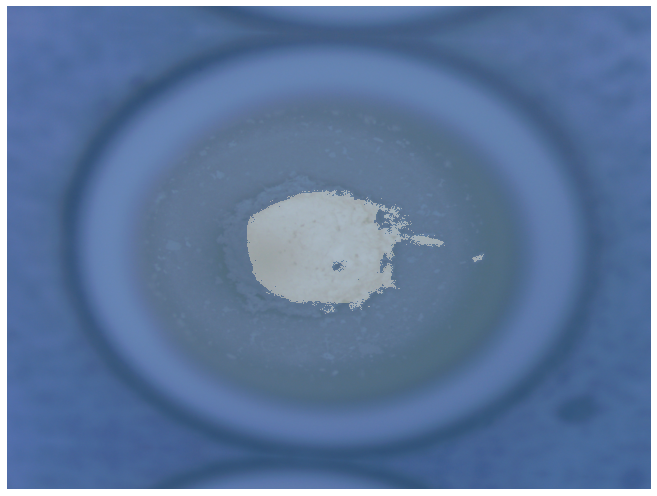

In [ ]:
data.show_batch(2, figsize=(10, 7))

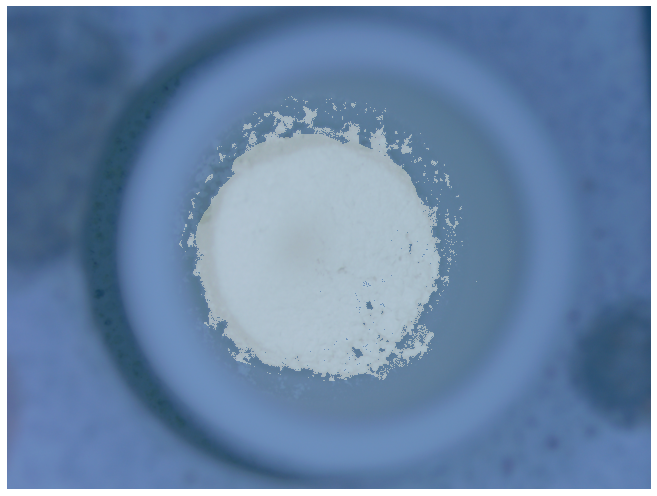

In [ ]:
data.show_batch(1, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = acc_camvid

In [ ]:
wd = 1e-2

In [ ]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


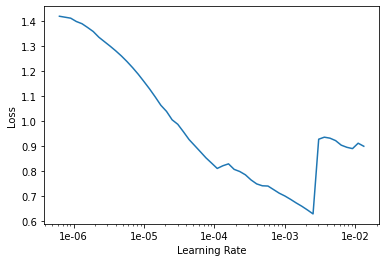

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.367360,0.187630,0.106048,00:30
1,0.250284,0.070935,0.708764,00:30
2,0.378405,0.736535,0.918337,00:30
3,0.405822,0.254709,0.000000,00:30
4,0.394477,0.184657,0.176300,00:30
5,0.300692,0.078613,0.790673,00:30
6,0.265633,0.152797,0.497996,00:31
7,0.255626,0.252377,0.899444,00:31
8,0.633276,0.100637,0.663977,00:31
9,0.442160,0.089265,0.793730,00:31


In [ ]:
learn.save('camvid-stage-1')

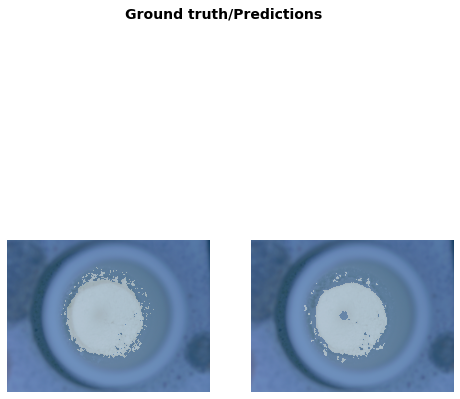

In [ ]:
learn.show_results(rows=3, figsize=(8, 9))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


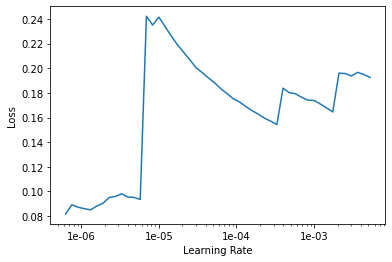

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.180300,0.089188,0.780261,00:32
1,0.165121,0.079903,0.760734,00:32
2,0.162103,0.089907,0.851780,00:32
3,0.138564,0.051689,0.832044,00:32
4,0.129807,0.049779,0.804483,00:32
5,0.156866,0.040474,0.792739,00:32
6,0.128916,0.040446,0.871527,00:32
7,0.099551,0.038636,0.841245,00:32
8,0.087251,0.126989,0.988488,00:32
9,0.090610,0.031460,0.884240,00:32


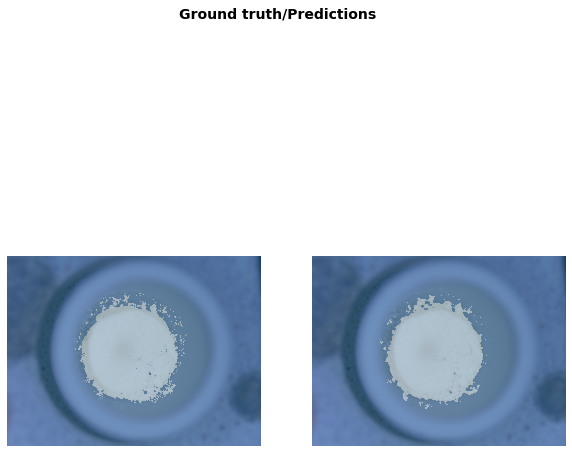

In [ ]:
learn.show_results(rows=1, figsize=(10, 10))

In [ ]:
learn.save('camvid-stage-2')

## Train on bigger images

In [ ]:
learn.destroy()

size = src_size // 1.5

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=3
else: 
  bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 14053MB of GPU RAM free


In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

Exception: ignored

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('camvid-stage-2');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('camvid-big-stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

In [ ]:
learn.save('stage-2-big')

## Interpretation

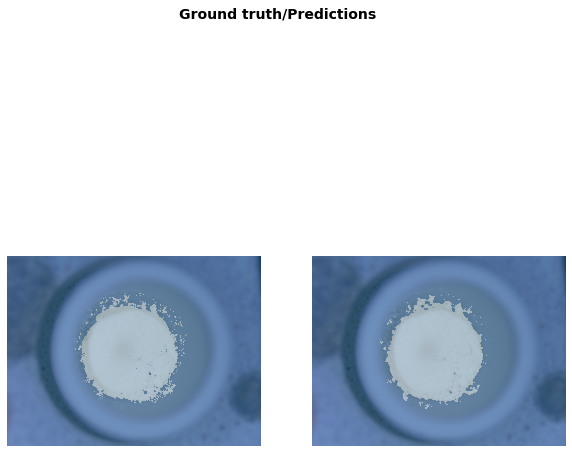

In [ ]:
learn.show_results(rows=1, figsize=(10, 10))

/content/drive/MyDrive/images/pred/A0150-0003.png


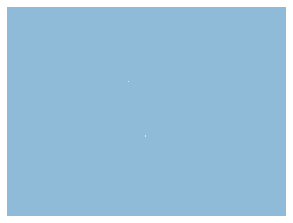

In [ ]:
img_f = fnames[25]
img_f = '/content/drive/MyDrive/images/pred/A0150-0003.png'
print (img_f)
img = open_image(img_f)
c =learn.predict(img)

c[0].save(f'{path_lbl}/9_mask.png') 
img = open_mask(f'{path_lbl}/9_mask.png')
img.show(figsize=(5,5))

In [ ]:
print(len(fnames))

126
